In [1]:
#All imports
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Loading and preprocessing the dataset..


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The first few rows:


,Score,Text
0,4.0,"It is a nice made necklace, and the butterfly ..."
1,4.0,I bought this necklace on a whim; I love butte...
2,5.0,"Bought via gold box ,it is much better than I ..."
3,NaN,I love this necklace. It is great for everyday...
4,5.0,"Love this butterfly pendant. Right size, high ..."


Training samples: 33204
Test samples: 8301

Class distribution in training data:
Score
5    17970
4     6863
3     3301
1     2922
2     2148
Name: count, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_12624\1770806794.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index, y=score_counts.values, palette='Blues_d')


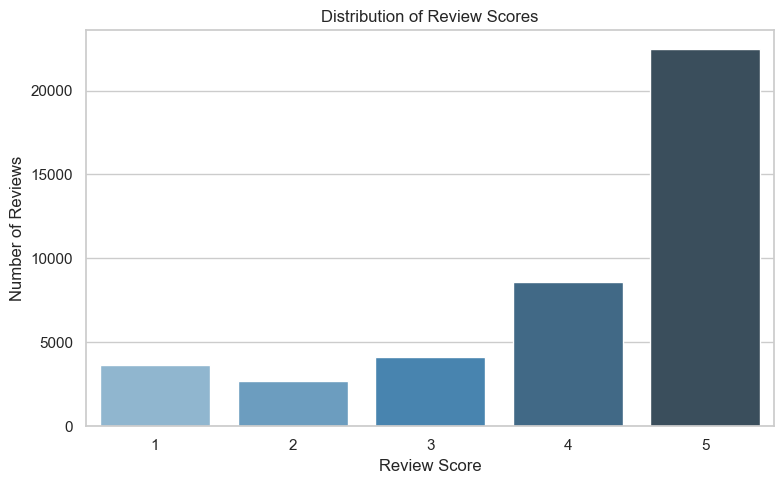


< Naive Bayes Model >
Predicted: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Ground truth: [5, 5, 5, 4, 3, 5, 2, 5, 1, 4]


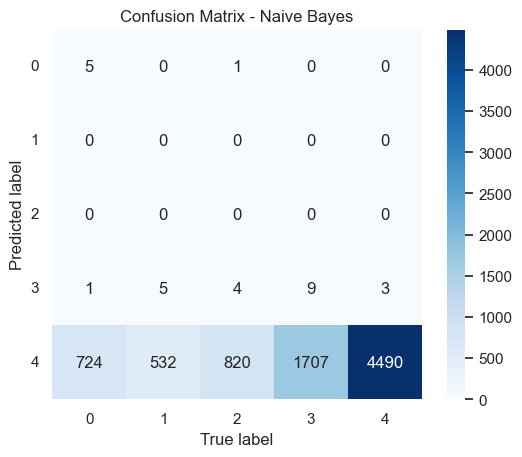

Accuracy:	0.542585
F1-score:	0.145475
Precision:	0.357031
Recall:		0.202285

Classification performance:
              precision    recall  f1-score   support

           1       0.83      0.01      0.01       730
           2       0.00      0.00      0.00       537
           3       0.00      0.00      0.00       825
           4       0.41      0.01      0.01      1716
           5       0.54      1.00      0.70      4493

    accuracy                           0.54      8301
   macro avg       0.36      0.20      0.15      8301
weighted avg       0.45      0.54      0.38      8301



C:\Users\Dell\anaconda3\envs\tf310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\envs\tf310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\envs\tf310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
#Loading data and cleaning it
print("Loading and preprocessing the dataset..")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.split()  # word_tokenize was not working so just split on whitespace
    return ' '.join([w for w in tokens if w not in stop_words])

#Load dataset now
raw_df = pd.read_csv("C:/Users/Dell/Downloads/dataset.csv")
print("The first few rows:")
display(raw_df.head())

#Cleaning missing and wrong rows
raw_df = raw_df.dropna(subset=['Score', 'Text'])
raw_df['Score'] = raw_df['Score'].astype(int)
raw_df['Processed_Text'] = raw_df['Text'].apply(preprocess)

#Dropping rows where the processed text is empty
raw_df = raw_df[raw_df['Processed_Text'].str.strip().astype(bool)]

#Removing duplicates
raw_df = raw_df.drop_duplicates()

#Train-test split 80-20
X = raw_df['Processed_Text']
y = raw_df['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Saving for CNN and LSTM
y_train_raw = y_train.copy()
y_test_raw = y_test.copy()

#Show data info
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])
print("\nClass distribution in training data:")
print(y_train.value_counts())

#Showing class distribution
sns.set(style="whitegrid")

score_counts = raw_df['Score'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=score_counts.index, y=score_counts.values, palette='Blues_d')
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

sns.set()

print("\n< Naive Bayes Model >")

#NB pipeline
nb_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_pipeline.fit(X_train, y_train)

#Predict
nb_preds = nb_pipeline.predict(X_test)

#The first 10 predictions
print("Predicted:", nb_preds.tolist()[0:10])
print("Ground truth:", y_test.tolist()[0:10])

#Confusion matrix heatmap
mat = confusion_matrix(y_test, nb_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cmap="Blues")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Confusion Matrix - Naive Bayes")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

#Metrics
print("Accuracy:\t%f" % accuracy_score(y_test, nb_preds))
print("F1-score:\t%f" % f1_score(y_test, nb_preds, average='macro'))
print("Precision:\t%f" % precision_score(y_test, nb_preds, average='macro', zero_division=0))
print("Recall:\t\t%f" % recall_score(y_test, nb_preds, average='macro', zero_division=0))
print("\nClassification performance:\n%s" % classification_report(y_test, nb_preds))

#Save model
pkl_filename = "naive_bayes_model.pkl"
with open("naive_bayes_model.pkl", "wb") as f:
    pickle.dump(nb_pipeline, f)


< Cross-Validating for k-NN >
k=1, accuracy=0.4867
k=3, accuracy=0.5155
k=5, accuracy=0.5507
k=7, accuracy=0.5634
k=9, accuracy=0.5710


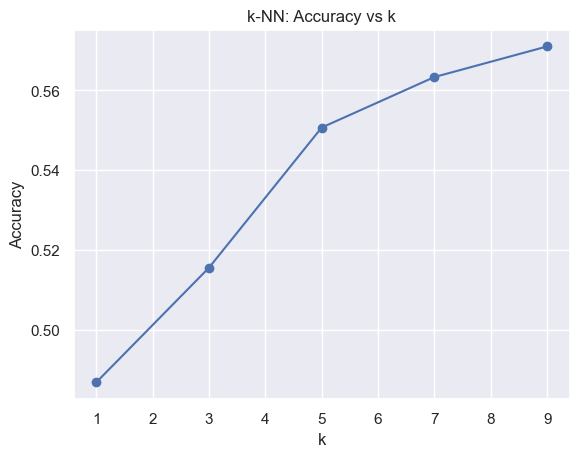


< Evaluation for k-NN >


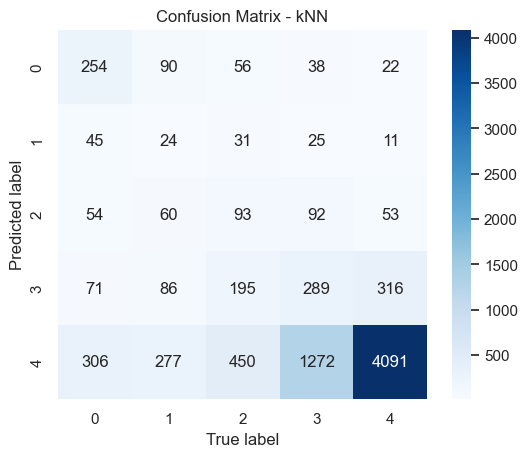

Accuracy:	0.572341
F1-score:	0.324776
Precision:	0.386891
Recall:		0.316862

Classification performance:
              precision    recall  f1-score   support

           1       0.55      0.35      0.43       730
           2       0.18      0.04      0.07       537
           3       0.26      0.11      0.16       825
           4       0.30      0.17      0.22      1716
           5       0.64      0.91      0.75      4493

    accuracy                           0.57      8301
   macro avg       0.39      0.32      0.32      8301
weighted avg       0.49      0.57      0.51      8301



In [3]:
print("\n< Cross-Validating for k-NN >")

k_choices = [1, 3, 5, 7, 9]
k_scores = []

#For best k , loop
for k in k_choices:
    knn_pipeline = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=k))
    score = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    print(f"k={k}, accuracy={score:.4f}")
    k_scores.append(score)

#Plot results
plt.plot(k_choices, k_scores, marker='o')
plt.title("k-NN: Accuracy vs k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

#training the final model using the best k
best_k = k_choices[k_scores.index(max(k_scores))]
knn_model = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=best_k))
knn_model.fit(X_train, y_train)

#predict on test set
knn_preds = knn_model.predict(X_test)

print("\n< Evaluation for k-NN >")

#confusion matrix
mat = confusion_matrix(y_test, knn_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='Blues')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Confusion Matrix - kNN")
plt.show()

#Performance metrics
print("Accuracy:\t%f" % accuracy_score(y_test, knn_preds))
print("F1-score:\t%f" % f1_score(y_test, knn_preds, average='macro'))
print("Precision:\t%f" % precision_score(y_test, knn_preds, average='macro'))
print("Recall:\t\t%f" % recall_score(y_test, knn_preds, average='macro'))

#Classification report
print("\nClassification performance:\n%s" % classification_report(y_test, knn_preds))

#Save model
pkl_filename = "knn_model.pkl"
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn_model, f)

Preparing data and vectorizer for LSTM model...
Vocabulary size: 20000
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 200)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 200, 100)          2000000   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                82

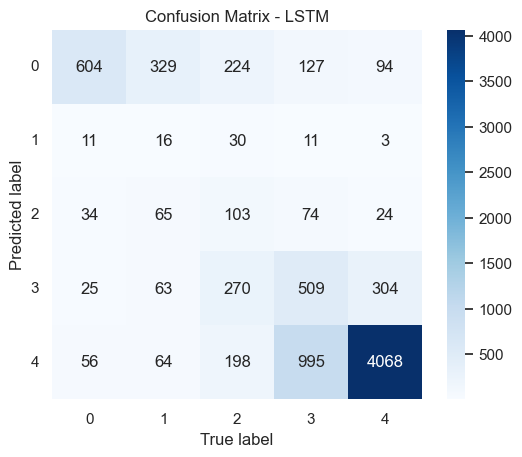

Accuracy:	0.638477
F1-score:	0.397079
Precision:	0.439533
Recall:		0.436814

Classification performance:
              precision    recall  f1-score   support

           1       0.44      0.83      0.57       730
           2       0.23      0.03      0.05       537
           3       0.34      0.12      0.18       825
           4       0.43      0.30      0.35      1716
           5       0.76      0.91      0.82      4493

    accuracy                           0.64      8301
   macro avg       0.44      0.44      0.40      8301
weighted avg       0.59      0.64      0.59      8301



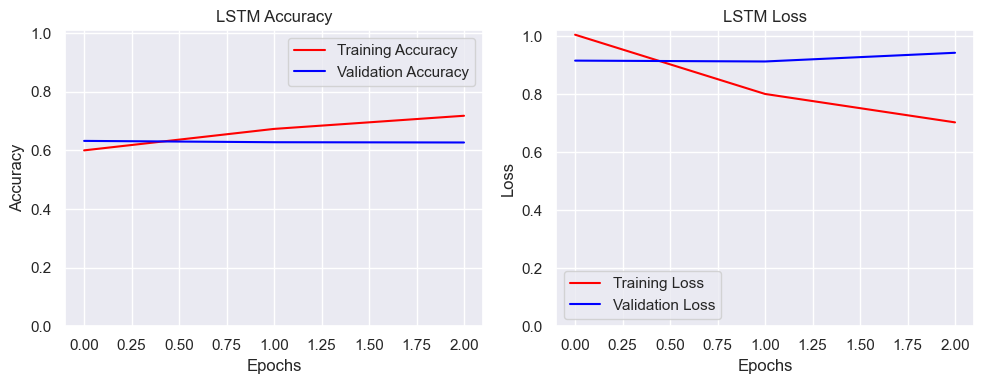

In [4]:
MAX_VOCABULARY_WORDS = 20000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100
NUM_CLASSES = 5

print("Preparing data and vectorizer for LSTM model...")
vectorizer = TextVectorization(
    max_tokens=MAX_VOCABULARY_WORDS,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)
vectorizer.adapt(X_train)
vocab = vectorizer.get_vocabulary()
print("Vocabulary size:", len(vocab))

#Adjusting labels
y_train_adj = (y_train_raw - 1).to_numpy()
y_test_adj = (y_test_raw - 1).to_numpy()

#LSTM model now to be built
model = Sequential(name="LSTM")
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer)
model.add(Embedding(input_dim=MAX_VOCABULARY_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)))
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

#Compiling it and training
opt = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
history = model.fit(
    X_train,
    y_train_adj,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[early]
)

#Predict now
print("\nPredicting on test set...")
pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)
pred_final = pred_classes + 1  

#Display the first 10 predictions
print("Predicted:", pred_final.tolist()[:10])
print("Ground truth:", y_test.tolist()[:10])

#Confusion matrix heatmap
mat = confusion_matrix(y_test, pred_final)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cmap="Blues")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Confusion Matrix - LSTM")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

#Printing classification metrics
print("Accuracy:\t%f" % accuracy_score(y_test, pred_final))
print("F1-score:\t%f" % f1_score(y_test, pred_final, average='macro'))
print("Precision:\t%f" % precision_score(y_test, pred_final, average='macro', zero_division=0))
print("Recall:\t\t%f" % recall_score(y_test, pred_final, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y_test, pred_final))

#Accuracy and loss plots
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('LSTM Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.ylim([0.0, 1.01])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('LSTM Loss')
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.ylim(bottom=0.0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

#Save model
model.save("lstm_model.keras", save_format='keras')


Training the CNN model...
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 200)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          64128     
                                                                 
 conv1d_1 (Conv1D)           (None, 194, 64)           24640     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 

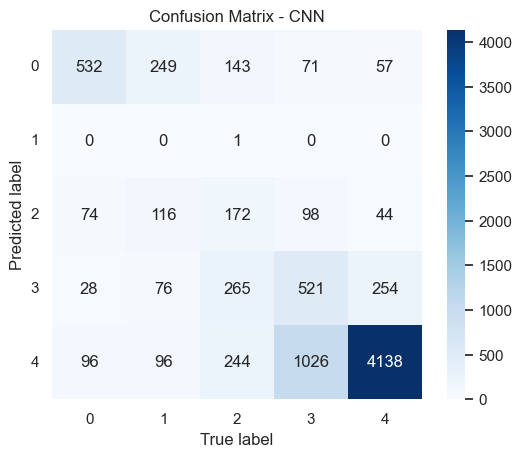

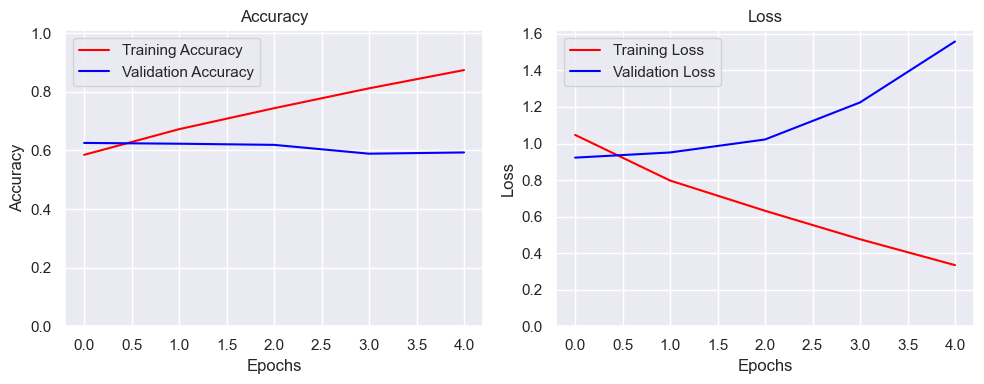

In [5]:
print("\nTraining the CNN model...")

#CNN model
cnn_model = Sequential(name="CNN")
cnn_model.add(Input(shape=(1,), dtype=tf.string))
cnn_model.add(vectorizer)
cnn_model.add(Embedding(input_dim=MAX_VOCABULARY_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(NUM_CLASSES, activation='softmax'))

cnn_model.summary()

#Compiling model
opt = Adam(learning_rate=0.001)
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#Training it
early_cnn = EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
cnn_history = cnn_model.fit(
    X_train,
    y_train_adj,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[early_cnn]
)

#Predicting now
print("\nPredicting with CNN model...")
cnn_pred_probs = cnn_model.predict(X_test)
cnn_pred_classes = np.argmax(cnn_pred_probs, axis=1)
cnn_final_preds = cnn_pred_classes + 1  # shift back to original label scale

#Evaluating it
print("Classification Report for CNN:")
print(classification_report(y_test, cnn_final_preds))

#Confusion Matrix
print("\nConfusion Matrix:")
mat = confusion_matrix(y_test, cnn_final_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cmap="Blues")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Confusion Matrix - CNN")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

#Plotting CNN accuracy and loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.ylim([0.0, 1.01])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(cnn_history.history['loss'], label='Training Loss', color='red')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='blue')
plt.ylim(bottom=0.0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

#Save model
cnn_model.save("cnn_model.keras", save_format='keras')

In [12]:
#Predict function for saved models
def predict_product_rating(text, model_file):
    print(f"\nLoading the model: {model_file}")
    print(f"Review text: {text}")

    if model_file.endswith(".pkl"):
        with open(model_file, "rb") as f:
            model = pickle.load(f)
        prediction = int(model.predict([text])[0])
        print(f"Predicted rating: {prediction}")
        return prediction

    elif model_file.endswith(".keras"):
        model = tf.keras.models.load_model(model_file)
        input_tensor = tf.convert_to_tensor([text])
        pred_probs = model.predict(input_tensor)
        prediction = np.argmax(pred_probs, axis=1)[0] + 1
        print(f"Predicted rating: {prediction}")
        return prediction

    else:
        raise ValueError("Unsupported model file format. Use '.pkl' or '.keras'.")

models = [
    "naive_bayes_model.pkl",
    "knn_model.pkl",
    "cnn_model.keras",
    "lstm_model.keras"
]

for model_path in models:
    predict_product_rating("The product is absolutely amazing and I'll recommend it to my network.", model_path)


Loading the model: naive_bayes_model.pkl
Review text: The product is absolutely amazing and I'll recommend it to my network.
Predicted rating: 5

Loading the model: knn_model.pkl
Review text: The product is absolutely amazing and I'll recommend it to my network.
Predicted rating: 5

Loading the model: cnn_model.keras
Review text: The product is absolutely amazing and I'll recommend it to my network.
1/1 [==============================] - 0s 349ms/step
Predicted rating: 5

Loading the model: lstm_model.keras
Review text: The product is absolutely amazing and I'll recommend it to my network.
1/1 [==============================] - 4s 4s/step
Predicted rating: 5


In [14]:
#Function for evaluation
def evaluate_model(model_file, X_test, y_test):
    if model_file.endswith(".pkl"):
        with open(model_file, "rb") as f:
            model = pickle.load(f)
        preds = model.predict([str(x) for x in X_test])
        preds = preds.astype(int)
    elif model_file.endswith(".keras"):
        model = tf.keras.models.load_model(model_file)
        input_tensor = tf.convert_to_tensor([str(x) for x in X_test])
        pred_probs = model.predict(input_tensor)
        preds = np.argmax(pred_probs, axis=1) + 1
    else:
        raise ValueError("File format is not supported.")
    
    return {
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds, average="macro"),
        "Precision": precision_score(y_test, preds, average="macro", zero_division=0),
        "Recall": recall_score(y_test, preds, average="macro")
    }

model_files = {
    "Naive Bayes": "naive_bayes_model.pkl",
    "k-NN": "knn_model.pkl",
    "CNN": "cnn_model.keras",
    "LSTM": "lstm_model.keras"
}

results = []
for name, file in model_files.items():
    metrics = evaluate_model(file, X_test, y_test)
    metrics["Model Name"] = name
    results.append(metrics)

df_validation = pd.DataFrame(results)
df_validation = df_validation[["Model Name", "Accuracy", "F1", "Precision", "Recall"]]

#Display
print("\nModel Evaluation Summary:")
display(df_validation)

260/260 [==============================] - 58s 206ms/step

Model Evaluation Summary:


,Model Name,Accuracy,F1,Precision,Recall
0,Naive Bayes,0.542585,0.145475,0.357031,0.202285
1,k-NN,0.572341,0.324776,0.386891,0.316862
2,CNN,0.646067,0.408047,0.408264,0.432371
3,LSTM,0.638477,0.397079,0.439533,0.436814


## 1. Dataset
I used a dataset that includes a review generated by the user on a scale from 1 to 5. The dataset revealed 59,622 rows out of which 18,117 were duplicate and so were eliminated. This ensured that the dataset I was working with now was unique, hence it reduced any chances of redundant data and bias in training. This dataset provides a broad spectrum of linguistic patterns and opinions. I showed a visualization of the distribution of review scores and the results were very interesting. It showed a class imbalance, especially because a large majority (<20,000) of the reviews had 5-star ratings. Scores like 2 and 1 make a small fraction with approximately 3,500 and 2,500. Scores of 3 and 4 represented approximately 4,500 and 8,000 reviews. In models, if there is a skew in class distribution, it can potentially cause bias which makes them favour the majority classes when training and predicting. Consequentially, key metrics like accuracy could mislead us. However, if such key metrics are complemented by recall, precision and F1 score, the story can be different.

Moreover, there were definite problems in the data quality. There were missing values in ‘Score’ or ‘Text’ fields which had to be removed. Duplicate reviews were eliminated, as mentioned earlier. The text of reviews had a lot of variety in terms of wrong grammar, spelling and punctuation. Such data can be hard to preprocess but the dataset can still be worked on if the limitations are worked on efficiently.
## Data Preparation
This phase was very important, especially to make sure that the input to the machine learning models remained clean and consistent. First, I converted all text data to lowercase. This gave me the opportunity to maintain consistency and reduce redundancy. Following this, I removed punctuation and alphanumeric characters through regular expressions. This helped me eliminate anything that could have a negative impact on how the machine learning model is learning. I removed stopwords like ‘the’, ‘is’ and ‘and’ by using the NLTK library. These are common words but as we have learnt, they are irrelevant to the features used by models.

I performed tokenization using the split() function. Although word_tokenize() was my primary option, and it is also much better to use, I was faced with compatibility problems that was consuming majority of my time. After confirming with Dr. Katsigiannis, I went ahead with split(), and it proved to be effective considering the dataset. After preprocessing the text, empty reviews were eliminated so that they do not impact the model in any way. I, then, split the dataset into training and testing subsets. I did this by using a 80-20 split. Through stratifying, I ensured that the original class distribution in both sets was maintained. Using softmax classification, I then adjusted the rating labels down to a zero based index from 0-4. 

I employed tfidf vectorization for Naive Bayes and k-NN. This helped me capture the term frequency, and also significantly reduced the impact of words that were very common. For neural network models (CNN and LSTM), I used TextVectorization. This helped me to convert raw text into a sequence of integers. These were transformed into dense vectors in order to make the models learn word relationships. All of this helped me to ensure that all models had the right input data for the way it learned it.

## Machine Learning Models
The four machine learning models used were Multinomial Naive Bayes, k-Nearest Neighbors (k-NN), a Convolutional Nueral Network (CNN) and a Long Short Term Memory network (LSTM). 

I implemented the Naive Bayes model by using a pipeline. This pipeline combined the tfidf vectorization with the MultinomialNB classifier. Although it provided a baseline quickly and performed decently considering the overall accuracy, it did fail to capture nuanced patterns in sentiment. The dataset had imbalance with a large majority leaning towards 5-star scores, and the model being simple in nature could not do well. However, it helped reduce the impact of terms used commonly.

The tfidf pipeline helped build the k-NN model and the different values of k (from 1 to 9) were tested. This was done through cross-validation and the best result was k=9. It was an easy to implement model but can react to features that might have features that are not of importance to it. It performed better than Naive Bayes but results showed poor recall in classes that had low scores.
The CNN model had embeddings processed by Conv1D layers that were followed by a ReLU activation. GlobalMaxPooling1D was used to ensure that output had a fixed size, producing a probability distribution across the five ratings classes. This model was suitable to view reviews that had important phrases of sentiment.

The LSTM model focused on ensuring that it learnt long-term dependencies in the text. By featuring two Bidirectional LSTM layers, it ensured processing the input sequences in forward and backward directions. This model, then, made sure to interpret sentence structures that were complex by capturing context from words surrounding it. This model had a slightly better precision and recall as compared to CNN but it was overfitting, which was shown by the training curves where the validation performance became stagnant and the training accuracy kept improving.
Naive Bayes and k-NN used sparse tfidf vectors while LSTM and CNN were more dependant on embeddings for learnings that were context sensitive.

## Experimental Results
The models were evaluated by using accuracy, F1 score, precision and recall to display a view of their classification performance. The results showed that CNN and LSTM performed better than k-NN and Naive Bayes in most metrics. The CNN scored the highest accuracy of 64.61% and next in line was LSTM with 63.85%. CNN also had the highest macro averaged F1 score of 0.408 which showed that precision and recall were balanced. LSTM was close to CNN with F1 score of 0.397 along with the highest recall at 0.4368. LSTM was better when detecting cases that were positive in all classes.

On the other hand, k-NN and Naive Bayes achieved a significantly lower performance. k-NN had a 57.23% accuracy and F1 score of 0.324, compared to Naive Bayes’ accuracy of 54.26% and a very poor F1 score of 0.145. Naive Bayes over predicted class 5 (it had majority reviews), which gave a boost to the overall accuracy. The confusion matrix validated the problem of not classifying minority classes properly as both had issues identifying class 2, which had a recall close to but not 0.

CNN and LSTM achieved recall values bigger than 0.90, especially in class 5. That said, these models also had issues with minority classes. I believe that the results show how important it is to give balance to the classes.

## Discussion
CNN and LSTM showed a clear advantage when tasked to handle complex structures. Due to its strength in detecting rich sentiment phrases, CNN achieved the highest accuracy and F1 score. The LSTM was lower in accuracy but it had a very strong recall and precision, thus making it a strong option to choose from especially when minority classes have sensitivity. 

Clear successes were achieved, but all the models struggled with the class imbalance. Considering that more than 50% of the reviews were rated 5, classes 2 and 1 were not presented thoroughly. Class 2, specifically was rare to be predicted by all models as can be seen in the confusion and performance matrix. Balancing techniques must be applied and SMOTE should be introduced.

Another clear limitation was overfitting. This was displayed in the LSTM model. The validation accuracy became stagnant earlier, with the validation loss rising rapidly. This was happening despite accuracy improving across the eopochs. By using early stopping, this issue was managed, and CNN displayed something similar. CNN, however, had a better generalization overall.

The predict_product_rating(text, model_file) had its clear strengths. It allowed me to deploy the models without training them again. By supporting .pkl and .keras formats, predictions for new reviews can easily be taken. I used a test case which showed that all models predicted a rating of 5 for a highly positive review.

The project showed that CNN and LSTM were beneficial when classifying review ratings, but in the future more effort should be shown to balance classes. Such an enhancement would improve the overall performance while also ensuring there remains validity of such models when applying them in real world situation.